# Tree / Orchard detection counting from high resolution satellite images
## Density Map Regression with U-Net (PyTorch)
---
**Pipeline:**
- Read GeoTIFF images & point annotations
- Convert point masks → Gaussian density maps
- Train a U-Net to regress density maps
- Evaluate with MAE / RMSE on tree counts

# Get Dataset

In [1]:
!git clone https://huggingface.co/datasets/harshinde/tree-orchard-detection

Cloning into 'tree-orchard-detection'...
remote: Enumerating objects: 412, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 412 (delta 3), reused 0 (delta 0), pack-reused 402 (from 1)
Receiving objects: 100% (412/412), 1002.39 KiB | 14.96 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Filtering content: 100% (195/195), 401.89 MiB | 84.30 MiB/s, done.


## Install Dependencies

In [2]:
# Run once if needed
# !pip install rasterio tqdm matplotlib scipy torch torchvision --quiet

## Imports

In [3]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import rasterio
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm          # notebook-friendly progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

print('All imports OK')

All imports OK


## Configuration

In [4]:
TRAIN_IMG   = '/kaggle/working/tree-orchard-detection/image/train'
TRAIN_MASK  = '/kaggle/working/tree-orchard-detection/annotation/train'
TEST_IMG    = '/kaggle/working/tree-orchard-detection/image/test'
TEST_MASK   = '/kaggle/working/tree-orchard-detection/annotation/test'

GAUSSIAN_SIGMA  = 2       # sigma for Gaussian density map smoothing
BATCH_SIZE      = 8
EPOCHS          = 20
LR              = 1e-3
PRED_THRESH     = 0.01    # density threshold → binary prediction mask
VIS_SAMPLES     = 4       # how many test samples to visualise
MODEL_SAVE_PATH = 'best_model.pth'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device : {DEVICE}')
if DEVICE.type == 'cuda':
    print(f'GPU    : {torch.cuda.get_device_name(0)}')

Device : cuda
GPU    : Tesla T4


## Utility Functions

In [5]:
def norm_band(arr: np.ndarray) -> np.ndarray:
    """Percentile-based normalization of a single raster band to [0, 1]."""
    arr = arr.astype(np.float32)
    valid = arr > 0
    lo, hi = (np.percentile(arr[valid], (2, 98)) if np.any(valid) else (0.0, 1.0))
    return np.clip((arr - lo) / (hi - lo + 1e-6), 0, 1)


def read_tif(path: str) -> np.ndarray:
    """Read up to 3 bands from a GeoTIFF → normalised float32 (C, H, W)."""
    with rasterio.open(path) as src:
        bands = [norm_band(src.read(i)) for i in range(1, min(4, src.count + 1))]
    return np.stack(bands, axis=0)


def tensor_to_rgb(img_tensor) -> np.ndarray:
    """
    (C, H, W) tensor with bands [B, G, R] → (H, W, 3) float32 [R, G, B].
    Safe to pass either a torch.Tensor or a numpy array.
    """
    img = img_tensor.cpu().numpy() if torch.is_tensor(img_tensor) else img_tensor
    return np.clip(np.stack([img[2], img[1], img[0]], axis=-1), 0, 1)


def point_mask_to_density(mask: np.ndarray, sigma: float = GAUSSIAN_SIGMA) -> np.ndarray:
    """Binary annotation mask → Gaussian density map (integral ≈ tree count)."""
    density = np.zeros(mask.shape, dtype=np.float32)
    density[mask > 0] = 1.0
    return gaussian_filter(density, sigma=sigma)


def density_to_binary(density: np.ndarray, threshold: float = PRED_THRESH) -> np.ndarray:
    """Threshold a density map to a binary presence/absence mask."""
    return (density > threshold).astype(np.uint8)


print('Utility functions defined')

Utility functions defined


## Dataset Class

In [6]:
class TreeDataset(Dataset):
    """Paired image + density-map dataset for tree orchard detection."""

    def __init__(self, img_dir: str, mask_dir: str):
        self.img_paths  = sorted(glob.glob(os.path.join(img_dir,  '*.tif')))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))
        assert len(self.img_paths) > 0, f'No .tif files found in {img_dir}'
        assert len(self.img_paths) == len(self.mask_paths), (
            f'Image/mask count mismatch: {len(self.img_paths)} vs {len(self.mask_paths)}'
        )

    def __len__(self) -> int:
        return len(self.img_paths)

    def __getitem__(self, idx: int):
        img = read_tif(self.img_paths[idx])                         # (C,H,W)
        with rasterio.open(self.mask_paths[idx]) as src:
            raw_mask = src.read(1)
        binary_mask = (raw_mask > 0).astype(np.uint8)              # (H,W)
        density     = point_mask_to_density(binary_mask)            # (H,W)
        return (
            torch.tensor(img,         dtype=torch.float32),         # (C,H,W)
            torch.tensor(density,     dtype=torch.float32).unsqueeze(0),  # (1,H,W)
            torch.tensor(binary_mask, dtype=torch.uint8),           # (H,W) for viz
        )


train_ds = TreeDataset(TRAIN_IMG, TRAIN_MASK)
test_ds  = TreeDataset(TEST_IMG,  TEST_MASK)
print(f'Train samples : {len(train_ds)}')
print(f'Test  samples : {len(test_ds)}')

# Show a single item shape
img0, den0, msk0 = train_ds[0]
print(f'Image shape   : {tuple(img0.shape)}')
print(f'Density shape : {tuple(den0.shape)}')
print(f'Mask shape    : {tuple(msk0.shape)}')

Train samples : 153
Test  samples : 40
Image shape   : (3, 512, 512)
Density shape : (1, 512, 512)
Mask shape    : (512, 512)


## Preview a Training Sample

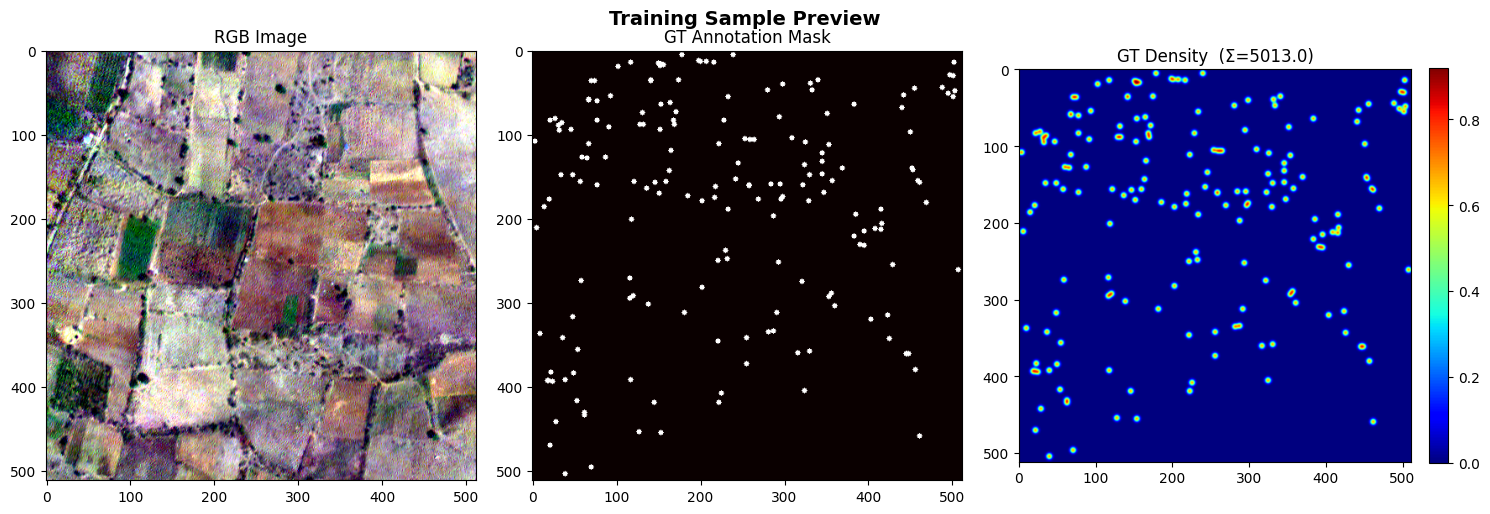

In [7]:
img_s, den_s, msk_s = train_ds[0]
rgb_s = tensor_to_rgb(img_s)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Training Sample Preview', fontsize=14, fontweight='bold')

axes[0].imshow(rgb_s);                     axes[0].set_title('RGB Image');              axes[0].axis('on')
axes[1].imshow(msk_s, cmap='hot');      axes[1].set_title('GT Annotation Mask');     axes[1].axis('on')
im = axes[2].imshow(den_s[0], cmap='jet'); axes[2].set_title(f'GT Density  (Σ={den_s[0].sum():.1f})'); axes[2].axis('on')
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## U-Net Model

In [8]:
def _cbr(in_ch: int, out_ch: int) -> nn.Sequential:
    """Conv(3×3) → BatchNorm → ReLU block."""
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    """
    Lightweight 3-level U-Net for density-map regression.
    Input : (B, 3, H, W)
    Output: (B, 1, H, W)  — non-negative density values
    """
    def __init__(self, in_channels: int = 3, out_channels: int = 1):
        super().__init__()
        self.enc1 = _cbr(in_channels, 32)
        self.enc2 = _cbr(32, 64)
        self.enc3 = _cbr(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.up2  = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = _cbr(128, 64)
        self.up1  = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = _cbr(64, 32)
        self.final = nn.Sequential(
            nn.Conv2d(32, out_channels, kernel_size=1),
            nn.ReLU(),          # ensures density ≥ 0
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.dec2(torch.cat([self.up2(e3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.final(d1)


model = UNet(in_channels=3).to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Model created  |  Trainable parameters: {total_params:,}')

Model created  |  Trainable parameters: 227,233


##  Metrics

In [9]:
def count_mae(pred: np.ndarray, gt: np.ndarray) -> float:
    """Absolute error between integrated predicted and GT tree count."""
    return float(abs(pred.sum() - gt.sum()))


def count_rmse(pred: np.ndarray, gt: np.ndarray) -> float:
    """Root-squared error between integrated predicted and GT tree count."""
    return float(np.sqrt((pred.sum() - gt.sum()) ** 2))


print('Metric functions defined')

Metric functions defined


## Train & Eval Loop Functions

In [10]:
def train_epoch(model, loader, optimizer, criterion) -> float:
    model.train()
    total_loss = 0.0
    for imgs, dens, _ in tqdm(loader, desc='  Train', leave=False):
        imgs, dens = imgs.to(DEVICE), dens.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(imgs), dens)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = mae = rmse = 0.0
    with torch.no_grad():
        for imgs, dens, _ in tqdm(loader, desc='  Val  ', leave=False):
            imgs, dens = imgs.to(DEVICE), dens.to(DEVICE)
            out  = model(imgs)
            loss = criterion(out, dens)
            total_loss += loss.item() * imgs.size(0)
            for i in range(imgs.size(0)):
                pred_np = out[i, 0].cpu().numpy()
                gt_np   = dens[i, 0].cpu().numpy()
                mae  += count_mae(pred_np, gt_np)
                rmse += count_rmse(pred_np, gt_np)
    n = len(loader.dataset)
    return total_loss / n, mae / n, rmse / n


print('Training functions defined')

Training functions defined


## Training

In [11]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1,          shuffle=False,
                          num_workers=2, pin_memory=True)
model     = UNet(in_channels=3).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# FIX: remove verbose=True — deprecated and removed in PyTorch 2.4+
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)

criterion = nn.MSELoss()
train_losses, val_losses, val_maes, val_rmses = [], [], [], []
best_mae = float('inf')

for epoch in range(EPOCHS):
    # track LR before scheduler step to detect changes 
    lr_before = optimizer.param_groups[0]['lr']
    print(f'\nEpoch [{epoch+1:>2}/{EPOCHS}]  |  LR: {lr_before:.2e}')
    t_loss                = train_epoch(model, train_loader, optimizer, criterion)
    v_loss, v_mae, v_rmse = eval_epoch(model,  test_loader,  criterion)
    scheduler.step(v_mae)

    #  print LR only if it actually changed
    lr_after = optimizer.param_groups[0]['lr']
    if lr_after != lr_before:
        print(f'LR reduced: {lr_before:.2e} → {lr_after:.2e}')
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    val_maes.append(v_mae)
    val_rmses.append(v_rmse)

    print(f'Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f} | '
          f'Val MAE: {v_mae:.2f} | Val RMSE: {v_rmse:.2f}')
    if v_mae < best_mae:
        best_mae = v_mae
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f'Best model saved  (MAE={best_mae:.2f})')
print(f'\n Training complete.  Best Val MAE: {best_mae:.2f}')


Epoch [ 1/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0130 | Val Loss: 0.0068 | Val MAE: 4689.35 | Val RMSE: 4689.35
Best model saved  (MAE=4689.35)

Epoch [ 2/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0068 | Val Loss: 0.0068 | Val MAE: 4589.93 | Val RMSE: 4589.93
Best model saved  (MAE=4589.93)

Epoch [ 3/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0068 | Val Loss: 0.0067 | Val MAE: 4518.41 | Val RMSE: 4518.41
Best model saved  (MAE=4518.41)

Epoch [ 4/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0067 | Val Loss: 0.0067 | Val MAE: 4054.29 | Val RMSE: 4054.29
Best model saved  (MAE=4054.29)

Epoch [ 5/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0066 | Val Loss: 0.0065 | Val MAE: 3479.24 | Val RMSE: 3479.24
Best model saved  (MAE=3479.24)

Epoch [ 6/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0064 | Val Loss: 0.0070 | Val MAE: 926.62 | Val RMSE: 926.62
Best model saved  (MAE=926.62)

Epoch [ 7/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0062 | Val Loss: 0.0062 | Val MAE: 1161.28 | Val RMSE: 1161.28

Epoch [ 8/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0061 | Val Loss: 0.0065 | Val MAE: 829.88 | Val RMSE: 829.88
Best model saved  (MAE=829.88)

Epoch [ 9/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0061 | Val Loss: 0.0058 | Val MAE: 2880.32 | Val RMSE: 2880.32

Epoch [10/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0060 | Val Loss: 0.0059 | Val MAE: 3289.57 | Val RMSE: 3289.57

Epoch [11/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0059 | Val Loss: 0.0057 | Val MAE: 2438.81 | Val RMSE: 2438.81

Epoch [12/20]  |  LR: 1.00e-03


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

LR reduced: 1.00e-03 → 5.00e-04
Train Loss: 0.0059 | Val Loss: 0.0056 | Val MAE: 1912.34 | Val RMSE: 1912.34

Epoch [13/20]  |  LR: 5.00e-04


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0058 | Val Loss: 0.0058 | Val MAE: 3197.64 | Val RMSE: 3197.64

Epoch [14/20]  |  LR: 5.00e-04


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0058 | Val Loss: 0.0058 | Val MAE: 950.53 | Val RMSE: 950.53

Epoch [15/20]  |  LR: 5.00e-04


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0057 | Val Loss: 0.0055 | Val MAE: 2070.07 | Val RMSE: 2070.07

Epoch [16/20]  |  LR: 5.00e-04


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

LR reduced: 5.00e-04 → 2.50e-04
Train Loss: 0.0057 | Val Loss: 0.0055 | Val MAE: 1405.09 | Val RMSE: 1405.09

Epoch [17/20]  |  LR: 2.50e-04


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0057 | Val Loss: 0.0057 | Val MAE: 815.42 | Val RMSE: 815.42
Best model saved  (MAE=815.42)

Epoch [18/20]  |  LR: 2.50e-04


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0057 | Val Loss: 0.0054 | Val MAE: 1757.78 | Val RMSE: 1757.78

Epoch [19/20]  |  LR: 2.50e-04


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0057 | Val Loss: 0.0060 | Val MAE: 1461.81 | Val RMSE: 1461.81

Epoch [20/20]  |  LR: 2.50e-04


  Train:   0%|          | 0/20 [00:00<?, ?it/s]

  Val  :   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.0057 | Val Loss: 0.0055 | Val MAE: 1492.25 | Val RMSE: 1492.25

 Training complete.  Best Val MAE: 815.42


## Training Curves

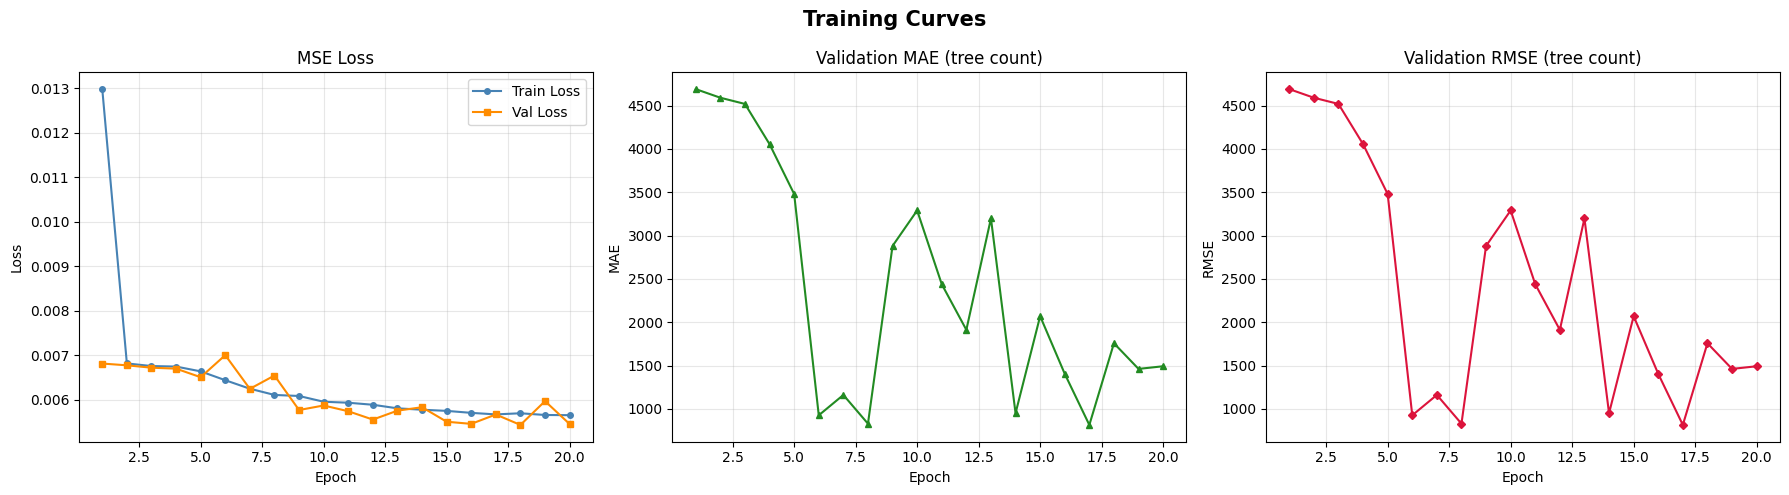

In [12]:
epochs_x = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training Curves', fontsize=15, fontweight='bold')

axes[0].plot(epochs_x, train_losses, label='Train Loss',
             color='steelblue',  marker='o', ms=4)
axes[0].plot(epochs_x, val_losses,   label='Val Loss',
             color='darkorange', marker='s', ms=4)
axes[0].set_title('MSE Loss')
axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].plot(epochs_x, val_maes, color='forestgreen', marker='^', ms=4)
axes[1].set_title('Validation MAE (tree count)')
axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('MAE')
axes[1].grid(alpha=0.3)

axes[2].plot(epochs_x, val_rmses, color='crimson', marker='D', ms=4)
axes[2].set_title('Validation RMSE (tree count)')
axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('RMSE')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Inference on Test Set

In [13]:
# Load best checkpoint
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()
print(f'Loaded best model from {MODEL_SAVE_PATH}')

# Collect predictions
all_imgs, all_gt_masks, all_gt_dens, all_pred_dens = [], [], [], []

with torch.no_grad():
    for imgs, dens, masks in tqdm(test_loader, desc='Inference'):
        imgs = imgs.to(DEVICE)
        pred = model(imgs)[0, 0].cpu().numpy()     # (H, W)
        all_imgs.append(tensor_to_rgb(imgs[0].cpu()))
        all_gt_masks.append(masks[0].numpy())
        all_gt_dens.append(dens[0, 0].numpy())
        all_pred_dens.append(pred)

print(f'Inference complete on {len(all_imgs)} samples ')

Loaded best model from best_model.pth


Inference:   0%|          | 0/40 [00:00<?, ?it/s]

Inference complete on 40 samples 


## Visualization
**5 panels per sample:** RGB | GT Mask | GT Density | Pred Density | Overlay

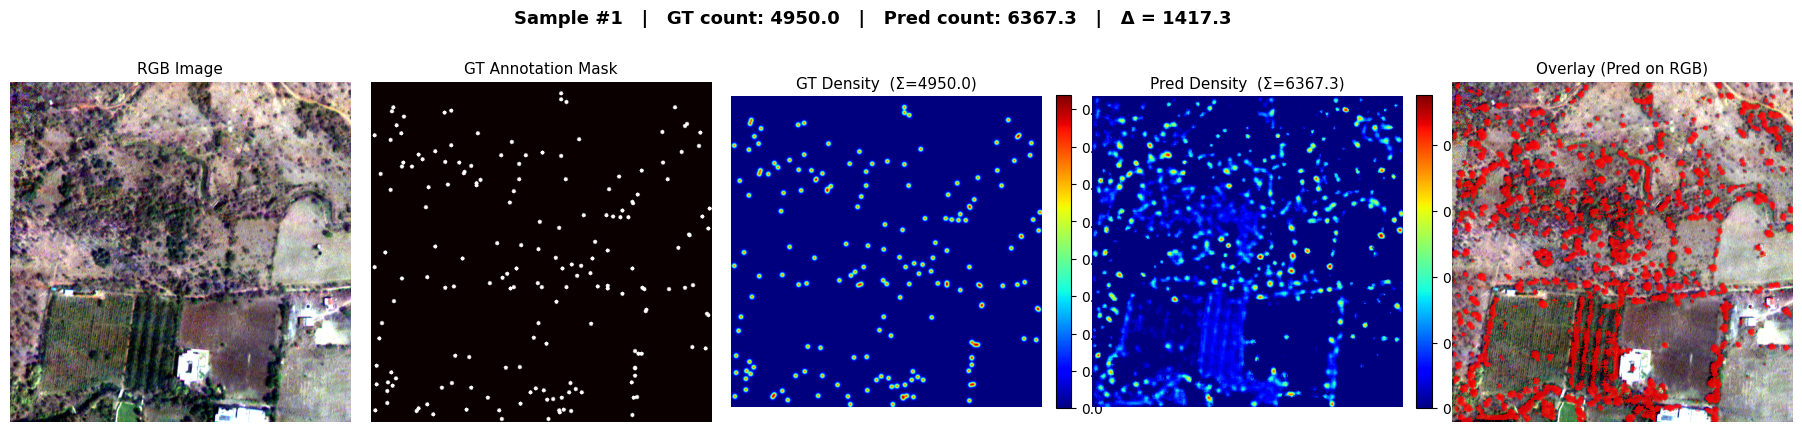

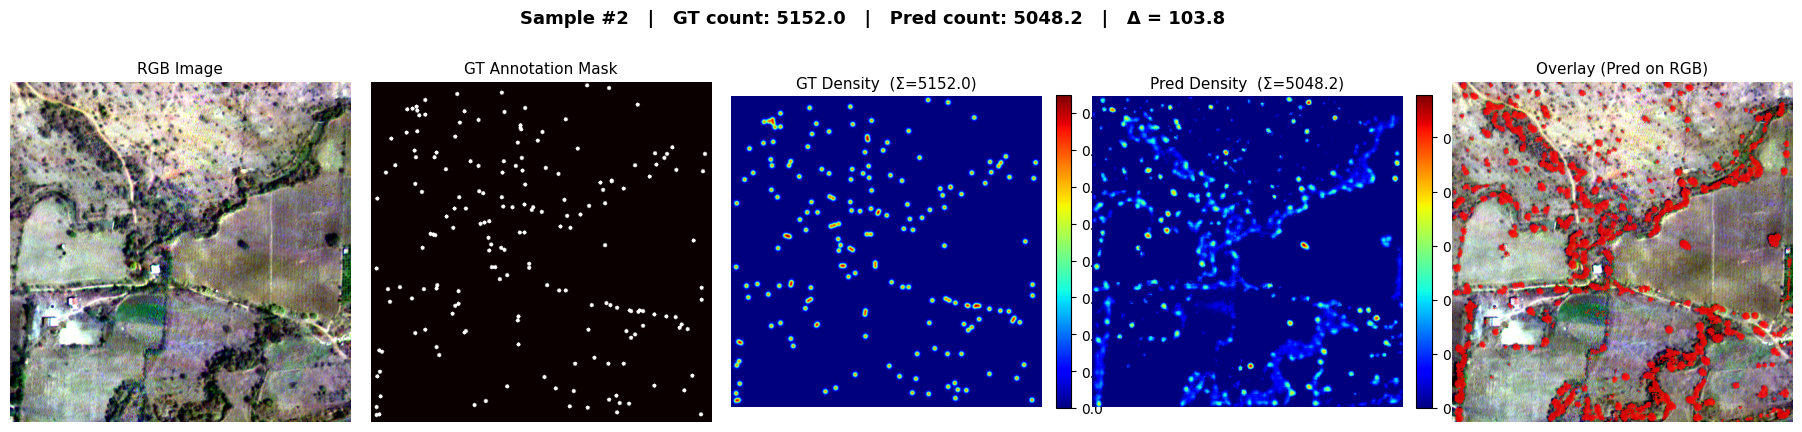

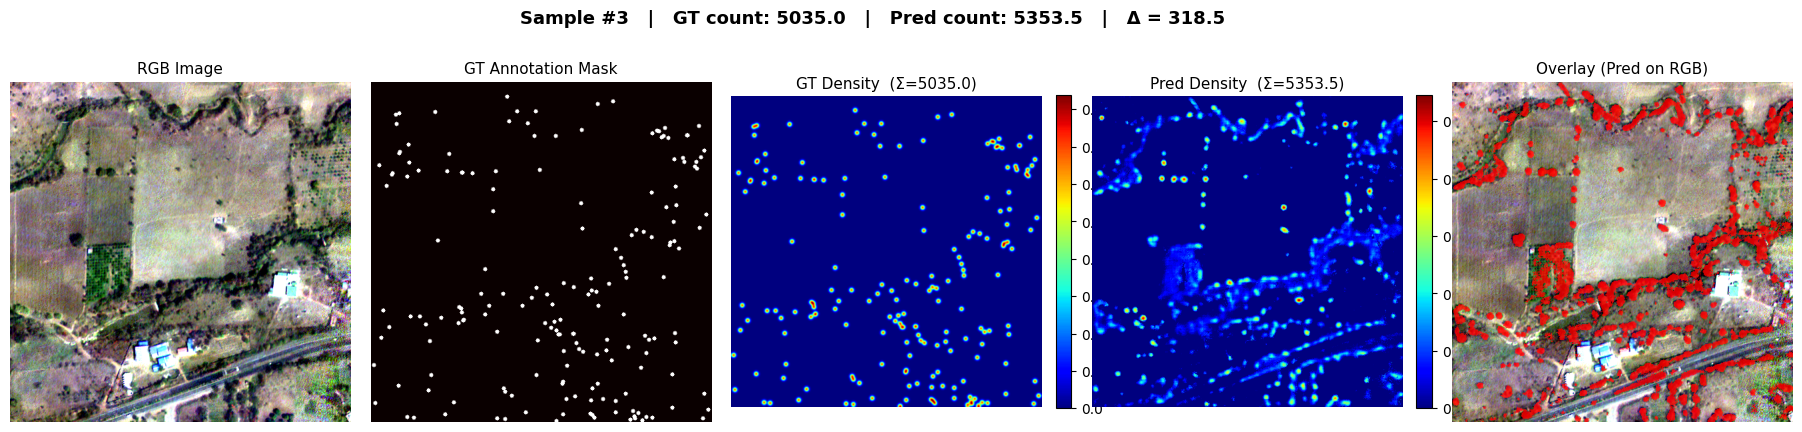

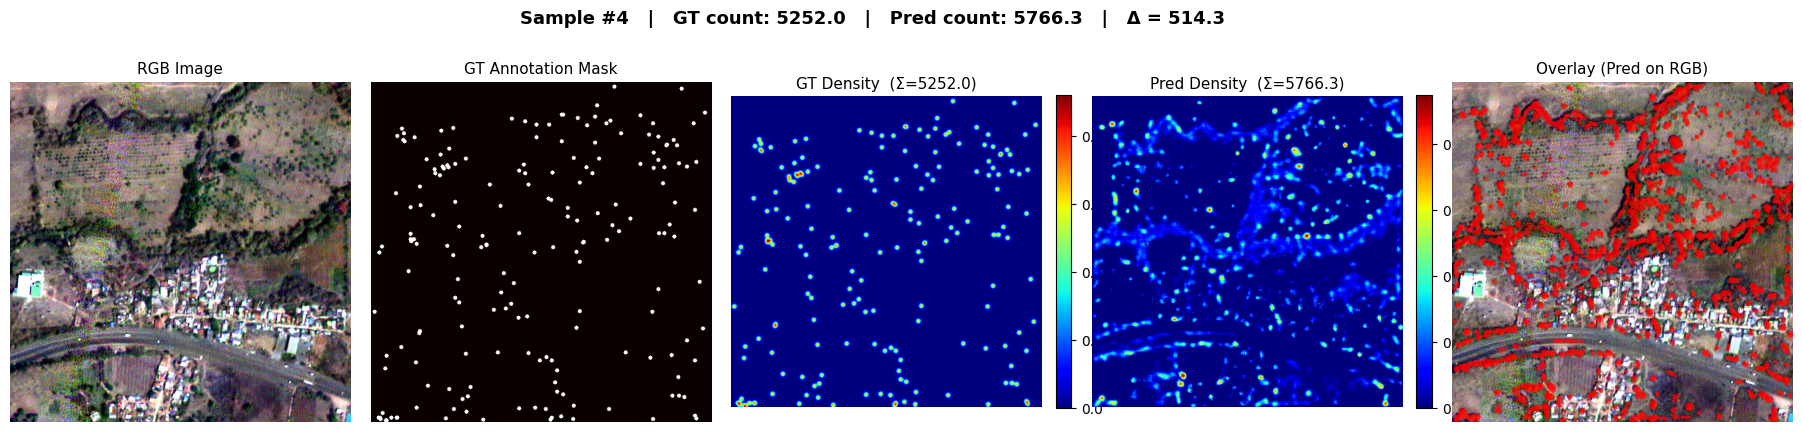

In [14]:
def plot_sample(rgb, gt_mask, gt_density, pred_dens, sample_idx):
    """
    5-panel figure:
      1. RGB image
      2. GT annotation (binary mask)
      3. GT density map
      4. Predicted density map
      5. Overlay — predicted heatmap blended onto RGB
    """
    gt_count   = float(gt_density.sum())
    pred_count = float(pred_dens.sum())
    delta      = abs(gt_count - pred_count)

    fig = plt.figure(figsize=(23, 5))
    fig.suptitle(
        f'Sample #{sample_idx + 1}   |   '
        f'GT count: {gt_count:.1f}   |   '
        f'Pred count: {pred_count:.1f}   |   '
        f'Δ = {delta:.1f}',
        fontsize=13, fontweight='bold',
    )
    gs = gridspec.GridSpec(1, 5, figure=fig, wspace=0.06)

    # RGB 
    ax = fig.add_subplot(gs[0])
    ax.imshow(rgb)
    ax.set_title('RGB Image', fontsize=11, pad=6)
    ax.axis('off')

    # GT Binary Mask 
    ax = fig.add_subplot(gs[1])
    ax.imshow(gt_mask, cmap='hot', vmin=0, vmax=1)
    ax.set_title('GT Annotation Mask', fontsize=11, pad=6)
    ax.axis('off')

    # GT Density 
    ax = fig.add_subplot(gs[2])
    im = ax.imshow(gt_density, cmap='jet')
    ax.set_title(f'GT Density  (Σ={gt_count:.1f})', fontsize=11, pad=6)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Predicted Density 
    ax = fig.add_subplot(gs[3])
    im = ax.imshow(pred_dens, cmap='jet')
    ax.set_title(f'Pred Density  (Σ={pred_count:.1f})', fontsize=11, pad=6)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Overlay: Pred heatmap blended onto RGB
    ax = fig.add_subplot(gs[4])
    # Apply threshold to only show meaningful predictions
    threshold = 0.1 * pred_dens.max()  # Show predictions above 10% of max
    mask = pred_dens > threshold
    # Create bright red overlay for detected areas
    overlay = rgb.copy()
    if np.any(mask):
        # Normalize only the values above threshold for better contrast
        norm_vals = (pred_dens - threshold) / (pred_dens.max() - threshold + 1e-6)
        norm_vals = np.clip(norm_vals, 0, 1)
        # Create bright red with varying intensity
        red_intensity = 0.8 + 0.2 * norm_vals[mask]  # Range from 0.8 to 1.0 for bright red
        # Apply red overlay to areas above threshold
        overlay[mask, 0] = overlay[mask, 0] * 0.3 + red_intensity  # Strong red channel
        overlay[mask, 1] = overlay[mask, 1] * 0.3                  # Dim green channel  
        overlay[mask, 2] = overlay[mask, 2] * 0.3                  # Dim blue channel   
    overlay = np.clip(overlay, 0, 1)
    ax.imshow(overlay)
    ax.set_title('Overlay (Pred on RGB)', fontsize=11, pad=6)
    ax.axis('off')
    plt.show()

#  Render VIS_SAMPLES samples 
for i in range(min(VIS_SAMPLES, len(all_imgs))):
    plot_sample(all_imgs[i], all_gt_masks[i], all_gt_dens[i], all_pred_dens[i], i)

# Prediction on Test Image

In [15]:
!wget -q https://huggingface.co/datasets/harshinde/tree-orchard-detection/resolve/main/original_tif_files/tree_orchard_count_new1.tif

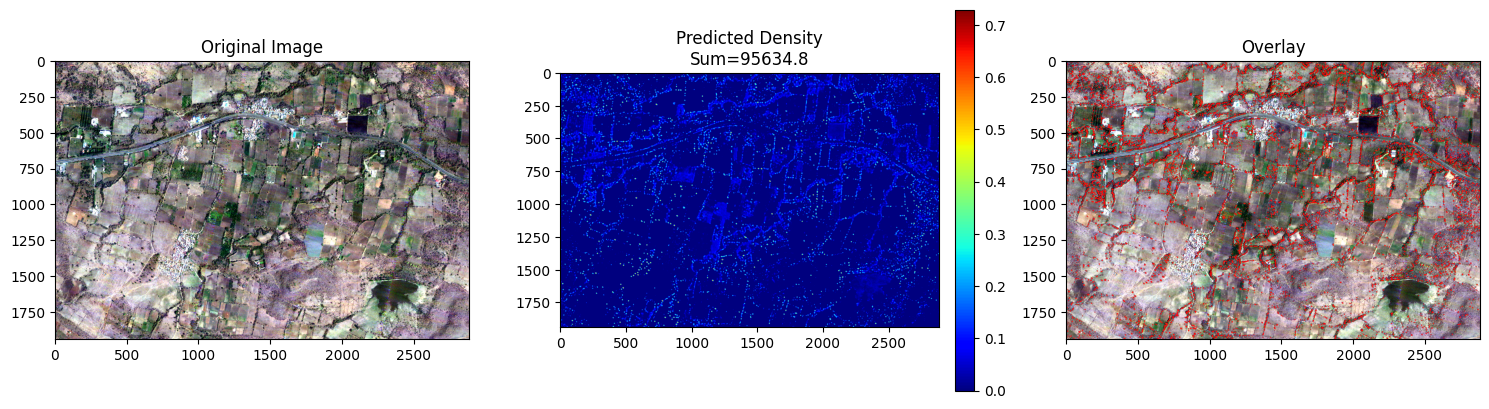

Total predicted count: 95634.77


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def infer_and_plot_on_image(image_path, model, device):

    def crop_to_multiple(img, multiple=4):
        c, h, w = img.shape
        h = h - (h % multiple)
        w = w - (w % multiple)
        return img[:, :h, :w]

    def make_overlay(rgb, dens):
        threshold = 0.1 * dens.max()
        mask = dens > threshold

        overlay = rgb.copy()

        if np.any(mask):
            norm = (dens - threshold) / (dens.max() - threshold + 1e-6)
            norm = np.clip(norm, 0, 1)

            overlay[mask, 0] = 1.0
            overlay[mask, 1] *= 0.3
            overlay[mask, 2] *= 0.3

        return np.clip(overlay, 0, 1)

    # ---- read ----
    img = read_tif(image_path)
    img = crop_to_multiple(img, 4)

    rgb = tensor_to_rgb(img)

    img_tensor = torch.tensor(
        img, dtype=torch.float32
    ).unsqueeze(0).to(device)

    # ---- predict ----
    model.eval()
    with torch.no_grad():
        pred = model(img_tensor)[0, 0].cpu().numpy()

    overlay = make_overlay(rgb, pred)

    # ---- BIG FIT GRID ----
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(rgb)
    ax[0].set_title("Original Image", fontsize=12)
    ax[0].axis("on")
    ax[0].set_aspect("equal")

    im = ax[1].imshow(pred, cmap="jet")
    ax[1].set_title(
        f"Predicted Density\nSum={pred.sum():.1f}",
        fontsize=12
    )
    ax[1].axis("on")
    ax[1].set_aspect("equal")

    ax[2].imshow(overlay)
    ax[2].set_title("Overlay", fontsize=12)
    ax[2].axis("on")
    ax[2].set_aspect("equal")

    fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()
    print("Total predicted count:", pred.sum())

# use
infer_and_plot_on_image(
    "/kaggle/working/tree_orchard_count_new1.tif",
    model,
    DEVICE,
)